In [5]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/Colab Notebooks/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
mean_dataset = np.load(path + '/mean_dataset.npy')
std_dataset = np.load(path + '/std_dataset.npy')
skew_dataset = np.load(path + '/skew_dataset.npy')
kurtosis_dataset = np.load(path + '/kurtosis_dataset.npy')
var_dataset = np.load(path + '/var_dataset.npy')
wmh_dataset = np.load(path + '/WMH_masks.npy')
flair_dataset = np.load(path + '/FLAIR_dataset.npy')

In [7]:
# flattening the dataset
flattened0 = mean_dataset.flatten()
flattened1 = std_dataset.flatten()
flattened2 = skew_dataset.flatten()
flattened3 = kurtosis_dataset.flatten()
flattened4 = wmh_dataset.flatten()
flattened5 = var_dataset.flatten()



In [8]:
data0 = flattened0
data1 = flattened1
data2 = flattened2
data3 = flattened3
data4 = flattened5
# Min-Max Normalization
normalized_data0 = (data0 - data0.min()) / (data0.max() - data0.min())
normalized_data1 = (data1 - data1.min()) / (data1.max() - data1.min())
normalized_data2 = (data2 - data2.min()) / (data2.max() - data2.min())
normalized_data3 = (data3 - data3.min()) / (data3.max() - data3.min())
normalized_data4 = (data4 - data4.min()) / (data4.max() - data4.min())


In [9]:
dataset = pd.DataFrame({'WMH':flattened4,'mean':normalized_data0, 'std':normalized_data1, 'skew':normalized_data2, 'kurt':normalized_data3, 'var':normalized_data4})


In [10]:
dataset.head(10)

,WMH,mean,std,skew,kurt,var
0,0.0,1.542783e-07,0.0,0.0,0.0,0.0
1,0.0,1.230760e-07,0.0,0.0,0.0,0.0
2,0.0,2.277471e-07,0.0,0.0,0.0,0.0
3,0.0,1.648659e-07,0.0,0.0,0.0,0.0
4,0.0,1.985127e-07,0.0,0.0,0.0,0.0
5,0.0,1.524473e-07,0.0,0.0,0.0,0.0
6,0.0,1.937342e-07,0.0,0.0,0.0,0.0
7,0.0,1.259006e-07,0.0,0.0,0.0,0.0
8,0.0,1.641970e-07,0.0,0.0,0.0,0.0
9,0.0,1.909893e-07,0.0,0.0,0.0,0.0


In [12]:
#downsampling the dataset

df_majority = dataset[dataset['WMH'] == 0]
df_minority = dataset[dataset['WMH'] == 1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=123)

df_downsampled = pd.concat([df_minority, df_majority_downsampled])

df_downsampled = df_downsampled.sample(frac=1, random_state=123).reset_index(drop=True)


In [14]:
print(df_downsampled.head())
print("Balanced dataset shape:", df_downsampled.shape)
print("Number of WMH pixels:", df_downsampled['WMH'].sum())
print("Number of healthy tissue pixels:", len(df_downsampled) - df_downsampled['WMH'].sum())

   WMH      mean       std      skew      kurt           var
0  0.0  0.000022  0.000003  0.502538  0.316272  1.053579e-11
1  0.0  0.000013  0.000002  0.755145  0.424944  2.848096e-12
2  1.0  0.000167  0.000031  0.540819  0.236956  9.845818e-10
3  1.0  0.000036  0.000020  0.569235  0.225622  3.851750e-10
4  0.0  0.440909  0.042233  0.502634  0.272311  1.783656e-03
Balanced dataset shape: (298276, 6)
Number of WMH pixels: 149138.0
Number of healthy tissue pixels: 149138.0


In [15]:
df_downsampled.describe()

,WMH,mean,std,skew,kurt,var
count,298276.000000,298276.000000,298276.000000,298276.000000,298276.000000,2.982760e+05
mean,0.500000,0.016414,0.004803,0.506296,0.258845,8.414633e-04
std,0.500001,0.083003,0.028608,0.205859,0.131281,1.046268e-02
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000017,0.000003,0.485099,0.233744,1.221429e-11
50%,0.500000,0.000031,0.000009,0.558698,0.259185,8.036314e-11
75%,1.000000,0.000061,0.000022,0.616550,0.298119,4.813616e-10
max,1.000000,1.000000,0.940436,1.000000,1.000000,8.844201e-01


In [16]:
# Split into features and target
X = df_downsampled.drop('WMH', axis=1)
y = df_downsampled['WMH']

# Split the data: 60% training, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=123, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)


In [17]:
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (178965, 5)
Validation set size: (59655, 5)
Test set size: (59656, 5)


In [20]:
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

# Function to build the model
def build_model(input_shape, seed=seed):
    tf.random.set_seed(seed)
    input_layer = Input(shape=input_shape, name='Input')

    hidden_layer = Dense(units=128, name='Hidden')(input_layer)
    hidden_activation = Activation('relu', name='HiddenActivation')(hidden_layer)
    dropout_layer = Dropout(0.5, name='Dropout')(hidden_activation)

    output_layer = Dense(units=1, name='Output')(dropout_layer)
    output_activation = Activation('sigmoid', name='Sigmoid')(output_layer)

    model = Model(inputs=input_layer, outputs=output_activation, name='Feedforward')

    optimizer = Adam(learning_rate=0.001)
    loss = BinaryCrossentropy()
    metrics = ['accuracy']

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model


In [21]:
input_shape = X_train.shape[1:]
model = build_model(input_shape)

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=2).history

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

# Predict the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

Epoch 1/30
5593/5593 - 14s - loss: 0.5794 - accuracy: 0.6624 - val_loss: 0.5644 - val_accuracy: 0.6733 - 14s/epoch - 2ms/step
Epoch 2/30
5593/5593 - 11s - loss: 0.5653 - accuracy: 0.6716 - val_loss: 0.5634 - val_accuracy: 0.6737 - 11s/epoch - 2ms/step
Epoch 3/30
5593/5593 - 13s - loss: 0.5642 - accuracy: 0.6723 - val_loss: 0.5626 - val_accuracy: 0.6738 - 13s/epoch - 2ms/step
Epoch 4/30
5593/5593 - 25s - loss: 0.5639 - accuracy: 0.6727 - val_loss: 0.5628 - val_accuracy: 0.6737 - 25s/epoch - 4ms/step
Epoch 5/30
5593/5593 - 17s - loss: 0.5636 - accuracy: 0.6733 - val_loss: 0.5617 - val_accuracy: 0.6739 - 17s/epoch - 3ms/step
Epoch 6/30
5593/5593 - 14s - loss: 0.5635 - accuracy: 0.6725 - val_loss: 0.5624 - val_accuracy: 0.6724 - 14s/epoch - 2ms/step
Epoch 7/30
5593/5593 - 11s - loss: 0.5627 - accuracy: 0.6740 - val_loss: 0.5644 - val_accuracy: 0.6720 - 11s/epoch - 2ms/step
Epoch 8/30
5593/5593 - 11s - loss: 0.5630 - accuracy: 0.6736 - val_loss: 0.5611 - val_accuracy: 0.6752 - 11s/epoch - 2

In [22]:
model.summary()

Model: "Feedforward"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 5)]               0         
                                                                 
 Hidden (Dense)              (None, 128)               768       
                                                                 
 HiddenActivation (Activati  (None, 128)               0         
 on)                                                             
                                                                 
 Dropout (Dropout)           (None, 128)               0         
                                                                 
 Output (Dense)              (None, 1)                 129       
                                                                 
 Sigmoid (Activation)        (None, 1)                 0         
                                                       

              precision    recall  f1-score   support

         0.0       0.79      0.48      0.60     29828
         1.0       0.63      0.88      0.73     29828

    accuracy                           0.68     59656
   macro avg       0.71      0.68      0.66     59656
weighted avg       0.71      0.68      0.66     59656



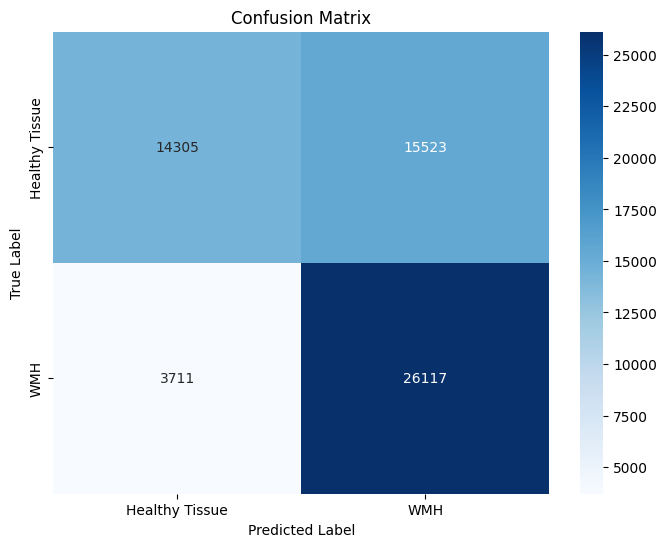

In [23]:
cm = confusion_matrix(y_test, y_pred_classes)

# The classification report
print(classification_report(y_test, y_pred_classes))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy Tissue', 'WMH'], yticklabels=['Healthy Tissue', 'WMH'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

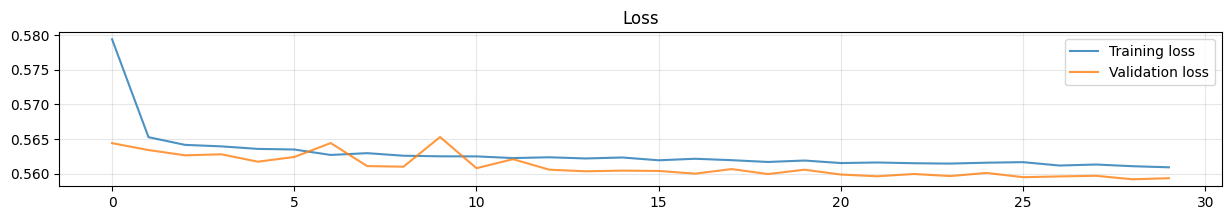

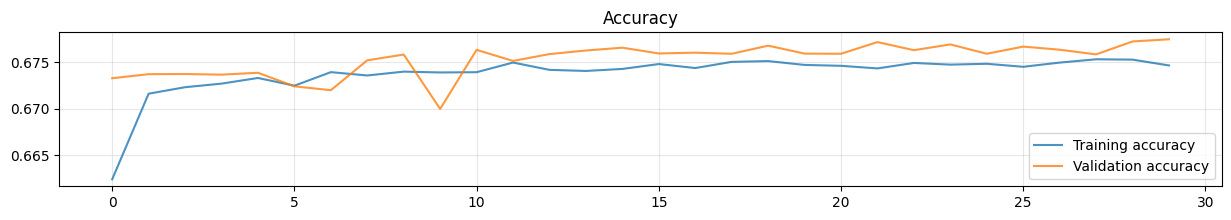

In [24]:
# Plots for training and validation loss
plt.figure(figsize=(15,2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plots for training and validation accuracy
plt.figure(figsize=(15,2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()